# This script demonstrates how to build a variational autoencoder with vae_tools

In [1]:
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt

python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.1
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


In [2]:
# Get the MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

Store model to filename: tmp/myVAE.png and tmp/myVAE.svg
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
enc_0 (Dense)                   (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
enc_1 (Dense)                   (None, 128)          32896       enc_0[0][0]                      
__________________________________________________________________________________________________
mean_0 (Dense)                  (None, 2)            258         enc_1[0][0]                      
_____________________________________

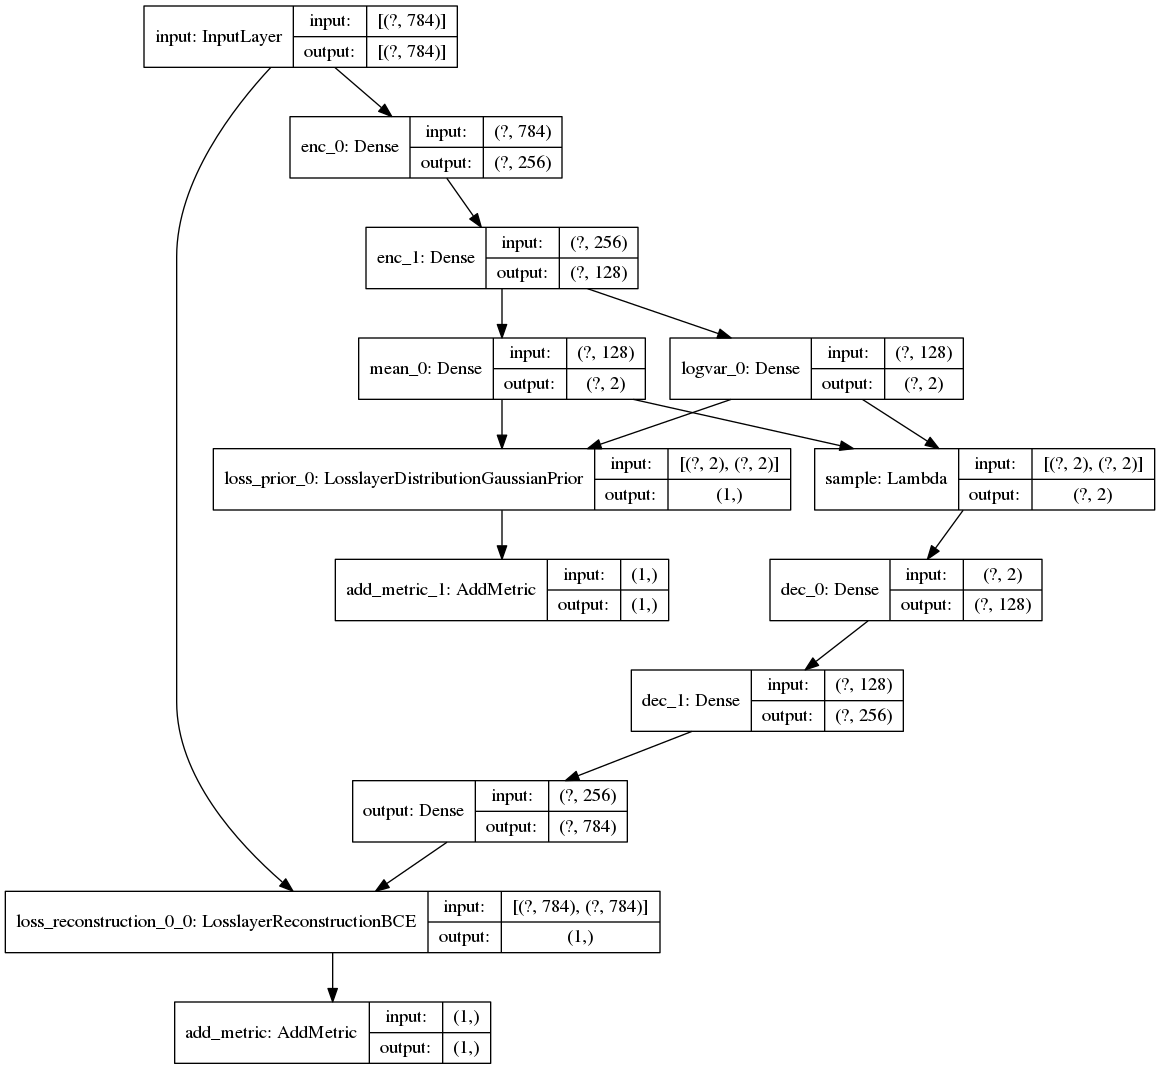

In [3]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
batch_size = 1024
original_dim = img_rows * img_cols * img_chns
intermediate_dim = 256
epochs = 10 # 50
z_dim = 2
beta = 1.

encoder = [[
    Input(shape=(original_dim,), name="input"),                       # Input layer
    Dense(intermediate_dim, activation='relu', name="enc_0"),         # First encoder layer
    Dense(int(intermediate_dim/2), activation='relu', name="enc_1")   # Second encoder layer
]]

decoder = [[
    Dense(int(intermediate_dim/2), activation='relu', name="dec_0"),  # First decoder layer
    Dense(intermediate_dim, activation='relu', name="dec_1"),         # Second decoder layer
    Dense(original_dim, activation='sigmoid', name="output")          # Output layer
]]

vae_obj = MmVae(z_dim, encoder, decoder, [original_dim], beta, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='Vae')

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

In [ ]:
# Store the losses, encodings, and decodings to tensorboard
# It is important to include the native Tensorboard callback as well besides vae_tools.callbacks.Tb*
log_dir = './Graph/mnist_wo_conv'

writer = tf.summary.create_file_writer(log_dir) # Get a writer for our own callbacks
np.savetxt(log_dir + "y_test.tsv", y_test, fmt="%d", delimiter="\t") # Store the labels for the embedding
# TODO fix behaviour of embeddings_metadata="y_test.tsv" in tensorflow 2.0
tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True, embeddings_freq=1, update_freq='epoch')
tbembedding_cb = vae_tools.callbacks.TbEmbedding(writer = writer, data = x_test, encoder_model = vae_obj.get_encoder_mean([encoder[0][0]]), labels = y_test, log_dir=log_dir)
tbdecoding_cb = vae_tools.callbacks.TbDecoding2dGaussian(writer = writer, decoder_model = vae_obj.get_decoder(), log_dir=log_dir)
# Train
h = vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None),
            verbose = 1,
            callbacks=[tb_cb, tbdecoding_cb, tbembedding_cb])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 144us/sample - loss: 244.9184 - loss_reconstruction_0_0: 231.6220 - loss_prior_0: 13.0335 - val_loss: 203.5306 - val_loss_reconstruction_0_0: 197.9377 - val_loss_prior_0: 5.5784

In [ ]:
# Show the losses (loss is ELBO)
vae_tools.viz.plot_losses(h, dpi=96, figsize_height_factor = .325)
plt.show()

In [ ]:
# build a digit generator that can sample from the learned distribution
generator = vae_obj.get_decoder()
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-1-i) * digit_size: ((n-1-i) + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
# build a model to project inputs on the latent space
encoder_input = [encoder[0][0]]
encoder_model = vae_obj.get_encoder_mean(encoder_input)
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder_model.predict(x_test, batch_size=batch_size)
f = plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.axis("equal")
plt.show()